In [93]:
import sys
import yaml
import matplotlib.pyplot as plt
import numpy as np
from motoman_def import robot_obj, positioner_obj
from robotics_utils import H_inv
import scipy
import matplotlib.animation as animation
import pickle
%matplotlib inline
# plt.rcParams['text.usetex'] = True

def rms_error(data):
    data = np.array(data)
    n = 0
    num = 0
    for i in data:
        if not np.isnan(i): 
            num = num + i**2
            n+=1
    return np.sqrt(num/n)

sys.path.append('../../toolbox')
from angled_layers import rotate, flame_tracking, avg_by_line, calc_velocity, SpeedHeightModel

In [2]:
recorded_dirs = [
    '../../../recorded_data/ER4043_bent_tube_2024_08_28_12_24_30/',
    '../../../recorded_data/ER4043_bent_tube_2024_09_04_12_23_40/',
    # '../../../recorded_data/ER4043_bent_tube_2024_09_03_13_26_16/'
]

# config_dir = "../../../upstream_repos/Welding_Motoman/config/"
config_dir = "../../config/"
flir_intrinsic = yaml.load(open(config_dir + "FLIR_A320.yaml"), Loader=yaml.FullLoader)
dataset = "bent_tube/"
sliced_alg = "slice_ER_4043/"
data_dir = "../../data/" + dataset + sliced_alg

with open(data_dir + "slicing.yml", "r") as file:
    slicing_meta = yaml.safe_load(file)

robot = robot_obj(
    "MA2010_A0",
    def_path=config_dir+"MA2010_A0_robot_default_config.yml",
    tool_file_path=config_dir+"torch_no_fujimount.csv",
    pulse2deg_file_path=config_dir+"MA2010_A0_pulse2deg_real.csv",
    d=15,
)
robot2 = robot_obj(
    "MA1440_A0",
    def_path=config_dir+"MA1440_A0_robot_default_config.yml",
    tool_file_path=config_dir+"flir.csv",
    pulse2deg_file_path=config_dir+"MA1440_A0_pulse2deg_real.csv",
    base_transformation_file=config_dir+"MA1440_pose.csv",
)
positioner = positioner_obj(
    "D500B",
    def_path=config_dir+"D500B_robot_default_config.yml",
    tool_file_path=config_dir+"positioner_tcp.csv",
    pulse2deg_file_path=config_dir+"D500B_pulse2deg_real.csv",
    base_transformation_file=config_dir+"D500B_pose.csv",
)

H2010_1440 = H_inv(robot2.base_H)
H = np.loadtxt(data_dir + "curve_pose.csv", delimiter=",")
p = H[:3, -1]
R = H[:3, :3]

height_offset = [-7.770, -4.85 , -5.71] #float(input("Enter height offset: "))
height_offset = [0,0,0]
job_no_offset = 3
point_of_rotation = np.array(
        (slicing_meta["point_of_rotation"], slicing_meta["baselayer_thickness"]))
base_thickness = slicing_meta["baselayer_thickness"]
layer_angle = np.array((slicing_meta["layer_angle"]))
print(layer_angle)
num_layer_start = 1
num_layer_end = 80
heights_all = []
flames_all = []
rms_err_all = []
for idx, recorded_dir in enumerate(recorded_dirs):
    flames = []
    heights = []
    for layer in range(num_layer_start, num_layer_end+1):
        print(f"Starting layer {layer}", end='\r')
        ### Load Data
        curve_sliced_js = np.loadtxt(
            data_dir + f"curve_sliced_js/MA2010_js{layer}_0.csv", delimiter=","
        ).reshape((-1, 6))

        positioner_js = np.loadtxt(
            data_dir + f"curve_sliced_js/D500B_js{layer}_0.csv", delimiter=","
        )
        curve_sliced_relative = np.loadtxt(
            data_dir + f"curve_sliced_relative/slice{layer}_0.csv", delimiter=","
        )
        curve_sliced = np.loadtxt(
            data_dir + f"curve_sliced/slice{layer}_0.csv", delimiter=","
        )
        to_flat_angle = np.deg2rad(layer_angle * (layer))
        dh_max = slicing_meta["dh_max"]
        dh_min = slicing_meta["dh_min"]
        
        ##calculate distance to point of rotation
        dist_to_por = []
        for i in range(len(curve_sliced)):
            point = np.array((curve_sliced[i, 0], curve_sliced[i, 2]))
            dist = np.linalg.norm(point - point_of_rotation)
            dist_to_por.append(dist)

        try:
            flame_3d, _, job_no = flame_tracking(f"{recorded_dir}layer_{layer}/", robot, robot2, positioner, flir_intrinsic, height_offset[idx])
            if flame_3d.shape[0] == 0:
                raise ValueError("No flame detected")
        except ValueError as e:
            print(e)
            flame_3d= None
        except FileNotFoundError as e:
            print(e)
            flame_3d = None
        else:
        # rotate to flat
            for i in range(flame_3d.shape[0]):
                flame_3d[i] = R.T @ flame_3d[i] 

            new_x, new_z = rotate(
                point_of_rotation, (flame_3d[:, 0], flame_3d[:, 2]), to_flat_angle
            )
            flame_3d[:, 0] = new_x
            flame_3d[:, 2] = new_z - base_thickness

            job_no= [i - job_no_offset for i in job_no]
            averages= avg_by_line(job_no, flame_3d, np.linspace(0,len(curve_sliced_js)-1,len(curve_sliced_js)))
            flames.append(averages)
            heights.append(averages[:,2])
    heights_all.append(heights)
    flames_all.append(flames)

1.1257976619508032


KeyboardInterrupt: 

In [11]:
with open("heights_all.pkl", 'wb') as file:
    pickle.dump(heights_all, file)

with open("flames_all.pkl", 'wb') as file:
    pickle.dump(flames_all, file)

In [3]:
# Load pickled variables

with open('heights_all.pkl', 'rb') as file:
    heights_all = pickle.load(file)
with open('flames_all.pkl', 'rb') as file:
    flames_all = pickle.load(file)

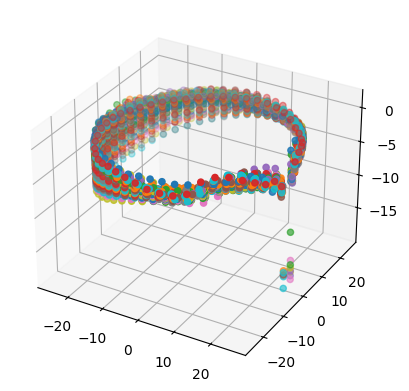

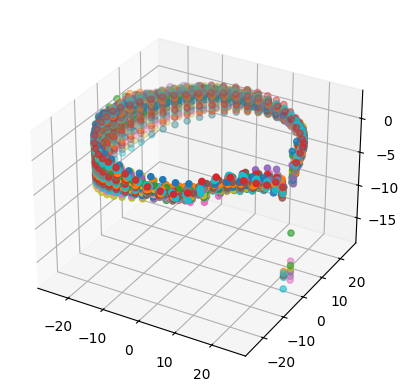

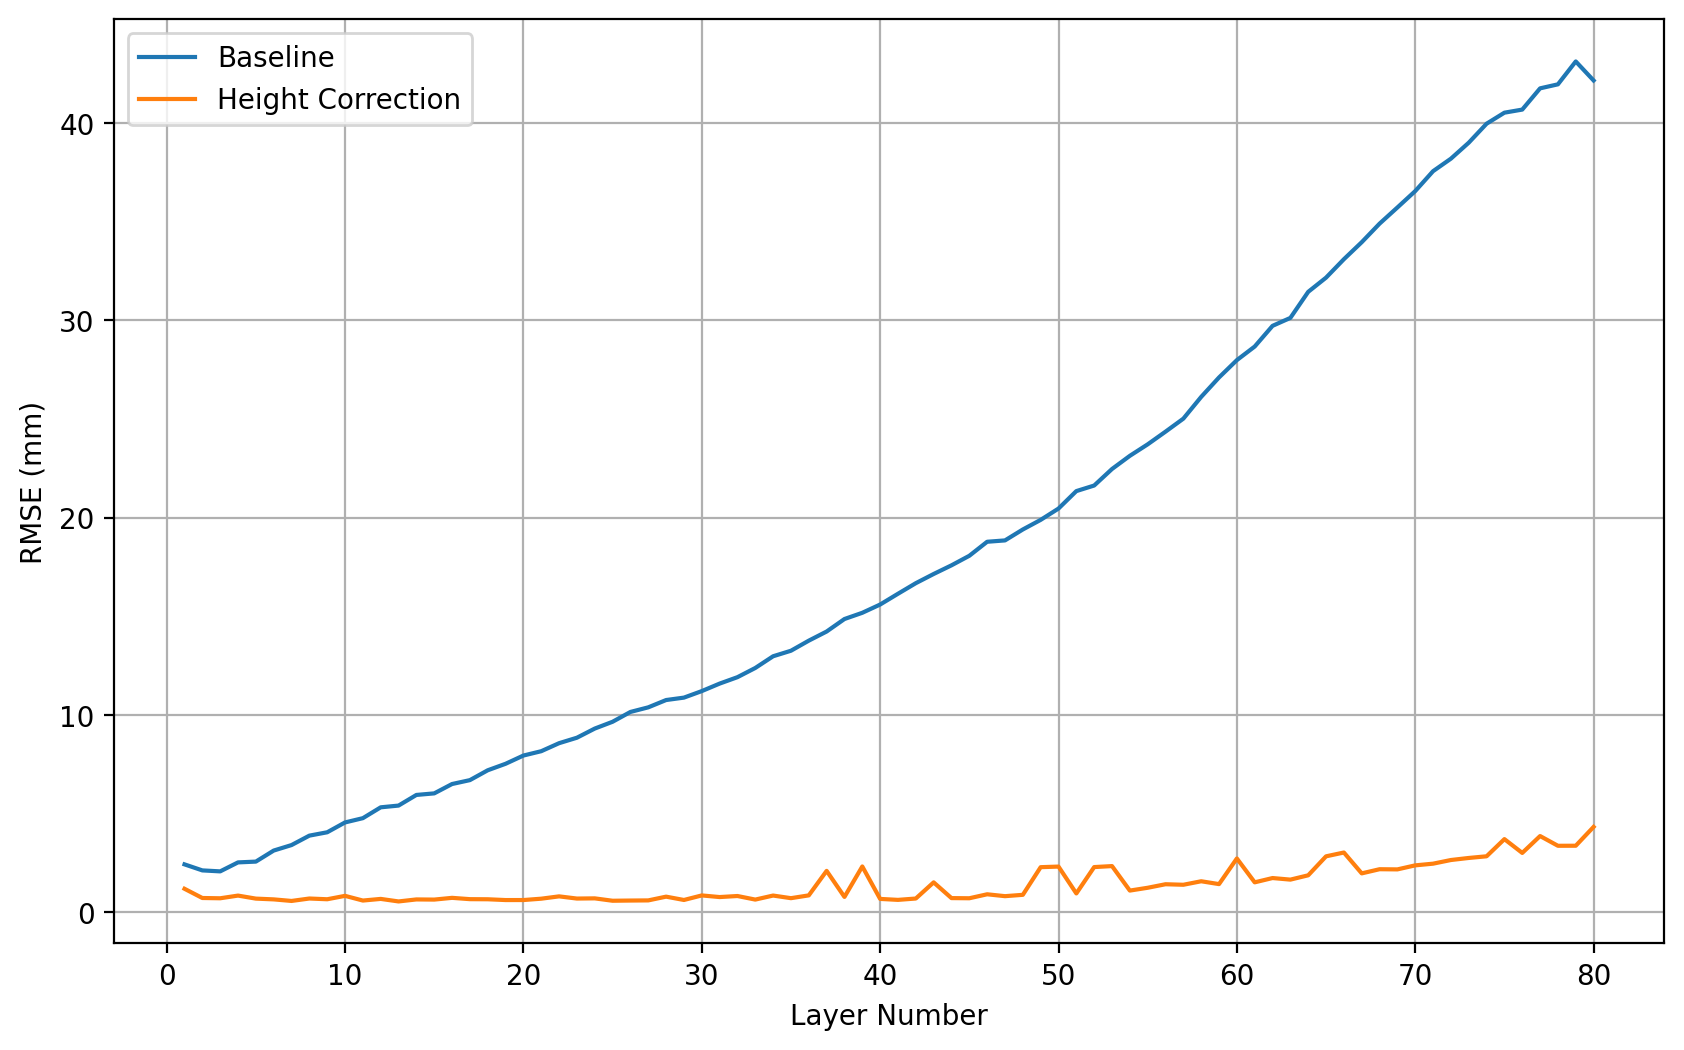

In [96]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
layers = range(1,81)
for flames in [flames_all[1]]:
    for flame in flames:
        ax.scatter(flame[:,0], flame[:,1], flame[:,2])
plt.show()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.set_dpi(200)
for heights in heights_all:
    rms_err = []
    for scan in heights:
        rms_err.append(rms_error(scan))
    ax.plot(layers,rms_err)
ax.set_xlabel("Layer Number")
ax.set_ylabel("RMSE (mm)")
ax.legend(["Baseline", "Height Correction"])
ax.grid()
plt.show()

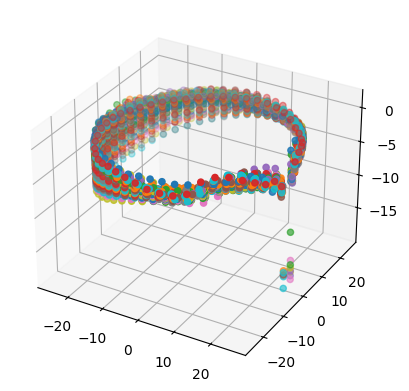

80
80
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True]
False


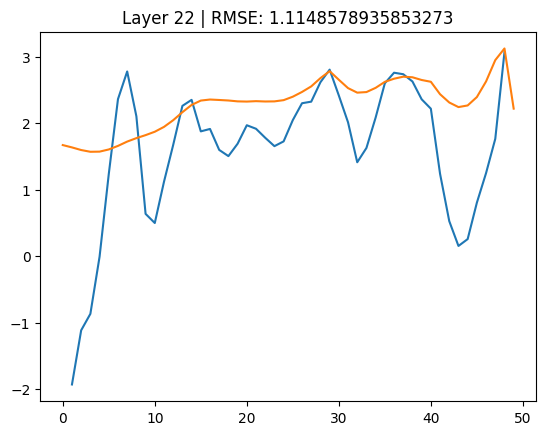

In [104]:
sample_idx = 1
## calculate flame position to measure dh
point_of_rotation = np.array(
        (slicing_meta["point_of_rotation"], 0))
flames_prev = []
for flame in flames_all[sample_idx]:  
    new_x, new_z = rotate(
                point_of_rotation, (flame[:, 0], flame[:, 2]), np.deg2rad(layer_angle)
    )
    flame_prev = np.zeros_like(flame)
    flame_prev[:,0] = new_x
    flame_prev[:,1] = flame[:,1]
    flame_prev[:,2] = new_z
    flames_prev.append(flame_prev)

fig = plt.figure()
ax = plt.axes(projection = '3d')
layers = range(1,81)
for flame in flames_prev:
    ax.scatter(flame[:,0], flame[:,1], flame[:,2])
plt.show() 
#Analyze dh's
recorded_dirs = [
    '../../../recorded_data/ER4043_bent_tube_2024_08_28_12_24_30/',   
    '../../../recorded_data/ER4043_bent_tube_2024_09_04_12_23_40/'
]
recorded_dir = recorded_dirs[sample_idx]
model = SpeedHeightModel()
expected_profs = []
for layer in range(1,81):
    vel = np.loadtxt(f"{recorded_dir}layer_{layer}/velocity_profile.csv", delimiter=',')
    if layer%2==0:
        expected_profs.append((model.v2dh(vel)))
    else:
        expected_profs.append(np.flip(model.v2dh(vel)))
        
dh_meas = []
print(len(flames_all[0]))
print(len(flames_prev))
for i in range(79):
    if i%2==0:
        dh_meas.append(flames_all[sample_idx][i+1][:,2] - np.flip(flames_prev[i][:,2]))
    else:
        dh_meas.append(np.flip(flames_all[sample_idx][i+1][:,2]) - flames_prev[i][:,2])
fig,ax = plt.subplots(1,1)
idx = 20
print(np.isnan(dh_meas[idx]))
print(np.any(np.isnan(expected_profs[idx+1])))
ax.plot(dh_meas[idx])
ax.plot(expected_profs[idx+1])
rmse = rms_error(expected_profs[idx+1]-dh_meas[idx]) #

ax.set_title(f"Layer {idx+2} | RMSE: {rmse}")
plt.show()

In [36]:
fig, ax = plt.subplots()
dataset = heights_all[1]
seg_idx = np.linspace(1,50,50)
frames = len(dataset)-1
ax.set_xlim([0,51])
ax.set_ylim([-10, 3])
ax.set_xlabel("Segment Index")
ax.set_ylabel("Height Error (mm)")
line, = ax.plot(seg_idx, dataset[0], color = 'r')
# account for start dir
dir = True
def update(frame):
    global dir
    # dir = not dir
    if not dir:
        line.set_ydata(np.flip(dataset[frame]))
    else:
        line.set_ydata(dataset[frame])
    return([line])

ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=200, blit=True)
ani.save("closedloop_zoom.gif")
plt.show()

In [52]:
dhs = []
vels = []
config_dir = "../../config/"
height_offset = -5.71
flir_intrinsic = yaml.load(open(config_dir + "FLIR_A320.yaml"), Loader=yaml.FullLoader)

################################ Data Directories ###########################
dataset = "bent_tube/"
sliced_alg = "slice_ER_4043/"
data_dir = "../../data/" + dataset + sliced_alg
rec_folder = 'ER4043_bent_tube_2024_09_03_13_26_16'
recorded_dir = "../../../recorded_data/" + rec_folder + "/"
with open(data_dir + "slicing.yml", "r") as file:
    slicing_meta = yaml.safe_load(file)

robot = robot_obj(
    "MA2010_A0",
    def_path=config_dir+"MA2010_A0_robot_default_config.yml",
    tool_file_path=config_dir+"torch.csv",
    pulse2deg_file_path=config_dir+"MA2010_A0_pulse2deg_real.csv",
    d=15,
)
robot2 = robot_obj(
    "MA1440_A0",
    def_path=config_dir+"MA1440_A0_robot_default_config.yml",
    tool_file_path=config_dir+"flir.csv",
    pulse2deg_file_path=config_dir+"MA1440_A0_pulse2deg_real.csv",
    base_transformation_file=config_dir+"MA1440_pose.csv",
)
positioner = positioner_obj(
    "D500B",
    def_path=config_dir+"D500B_robot_default_config.yml",
    tool_file_path=config_dir+"positioner_tcp.csv",
    pulse2deg_file_path=config_dir+"D500B_pulse2deg_real.csv",
    base_transformation_file=config_dir+"D500B_pose.csv",
)
H2010_1440 = H_inv(robot2.base_H)

H = np.loadtxt(data_dir + "curve_pose.csv", delimiter=",")
p = H[:3, -1]
R = H[:3, :3]

###set up control parameters
job_offset = 200  ###200 for Aluminum ER4043
feedrate_cmd = 160
base_feedrate_cmd = 300
base_vd = 5.0
measure_distance = 500
pos_vel = 10.0
jog_vd = 4.0
job_no_offset = 3
print("----------Normal Layers-----------")
num_layer_start = 1  ###modify layer num here
num_layer_end = 81
point_of_rotation = np.array(
        (slicing_meta["point_of_rotation"], slicing_meta["baselayer_thickness"])
    )

base_thickness = slicing_meta["baselayer_thickness"]
print("start layer: ", num_layer_start)
print("end layer: ", num_layer_end)
layer_angle = np.array((slicing_meta["layer_angle"]))


for layer in range(num_layer_start, num_layer_end):
    ### Load Data
    curve_sliced_js = np.loadtxt(
        data_dir + f"curve_sliced_js/MA2010_js{layer}_0.csv", delimiter=","
    ).reshape((-1, 6))

    positioner_js = np.loadtxt(
        data_dir + f"curve_sliced_js/D500B_js{layer}_0.csv", delimiter=","
    )
    curve_sliced_relative = np.loadtxt(
        data_dir + f"curve_sliced_relative/slice{layer}_0.csv", delimiter=","
    )
    curve_sliced = np.loadtxt(
        data_dir + f"curve_sliced/slice{layer}_0.csv", delimiter=","
    )
    to_flat_angle = np.deg2rad(layer_angle * (layer - 1))
    dh_max = slicing_meta["dh_max"]
    dh_min = slicing_meta["dh_min"]
    
    ##calculate distance to point of rotation
    dist_to_por = []
    for i in range(len(curve_sliced)):
        point = np.array((curve_sliced[i, 0], curve_sliced[i, 2]))
        dist = np.linalg.norm(point - point_of_rotation)
        dist_to_por.append(dist)

    height_profile = []
    for distance in dist_to_por:
        height_profile.append(distance * np.sin(np.deg2rad(layer_angle)))

    if layer == 1: 
        start_dir=True
    else: 
        start_dir = not np.loadtxt(f"{recorded_dir}layer_{layer-1}/start_dir.csv", delimiter=",")
        # Initialize model with previous layer's coefficients
        # model_coeff = np.loadtxt(f"{recorded_dir}layer_{layer-1}/coeff_mat.csv", delimiter=",")
        # model_p = np.loadtxt(f"{recorded_dir}layer_{layer-1}/model_p.csv", delimiter=",")
        # model = SpeedHeightModel(a = model_coeff[0], b = model_coeff[1], p = model_p)

        
        ir_error_flag = False
        ### Process IR data prev 
        try:
            flame_3d_prev, _, job_no_prev = flame_tracking(f"{recorded_dir}layer_{layer-1}/", robot, robot2, positioner, flir_intrinsic, height_offset)
            if flame_3d_prev.shape[0] == 0:
                raise ValueError("No flame detected")
        except ValueError as e:
            print(e)
            flame_3d_prev = None
            ir_error_flag = True
            print("2")
        else:
            # rotate to flat
            for i in range(flame_3d_prev.shape[0]):
                flame_3d_prev[i] = R.T @ flame_3d_prev[i] 
            
            new_x, new_z = rotate(
                point_of_rotation, (flame_3d_prev[:, 0], flame_3d_prev[:, 2]), to_flat_angle
            )
            flame_3d_prev[:, 0] = new_x
            flame_3d_prev[:, 2] = new_z - base_thickness

            job_no_prev = [i - job_no_offset for i in job_no_prev]
            averages_prev = avg_by_line(job_no_prev, flame_3d_prev, np.linspace(0,len(curve_sliced_js)-1,len(curve_sliced_js)))
            heights_prev = averages_prev[:,2]
            if start_dir: heights_prev = np.flip(heights_prev)
            # Find Valid datapoints for height correction
            prev_idx = np.argwhere(np.invert(np.isnan(heights_prev)))

            ### Process IR data 2 prev
            try:
                flame_3d_prev_2, _, job_no_prev_2 = flame_tracking(
                        f"{recorded_dir}layer_{layer-2}/",
                        robot,
                        robot2,
                        positioner,
                        flir_intrinsic,
                        height_offset
                )
                print(flame_3d_prev_2.shape)
            except ValueError as e:
                print(e)
                print("1")
                ir_error_flag = True
            else:
                print(ir_error_flag)
                # rotate to flat
                for i in range(flame_3d_prev_2.shape[0]):
                    flame_3d_prev_2[i] = R.T @ flame_3d_prev_2[i] 
                
                new_x, new_z = rotate(
                    point_of_rotation, 
                    (flame_3d_prev_2[:, 0], flame_3d_prev_2[:, 2]),
                    to_flat_angle
                )
                flame_3d_prev_2[:, 0] = new_x
                flame_3d_prev_2[:, 2] = new_z - base_thickness

                job_no_prev_2 = [i - job_no_offset for i in job_no_prev_2]
                averages_prev_2 = avg_by_line(job_no_prev_2, flame_3d_prev_2, np.linspace(0,len(curve_sliced_js)-1,len(curve_sliced_js)))
               
                heights_prev_2 = averages_prev_2[:,2]
                if not start_dir: heights_prev_2 = np.flip(heights_prev_2)
                # Find Valid datapoints for height correction
                prev_idx_2 = np.argwhere(np.invert(np.isnan(heights_prev_2)))

                # Calculate Cartesian Velocity
                calc_vel, job_nos_vel, _ = calc_velocity(f"{recorded_dir}layer_{layer-1}/",robot)
                job_nos_vel = [i - job_no_offset for i in job_nos_vel]
                vel_avg = avg_by_line(job_nos_vel, calc_vel, np.linspace(0,len(curve_sliced_js)-1, len(curve_sliced_js))).reshape(-1)
                
                # correct direction if start dir is in the opposite direction
                if start_dir:
                    vel_avg = np.flip(vel_avg)
                vel_valid_idx = np.argwhere(np.invert(np.isnan(vel_avg)))
                
                valid_idx = np.intersect1d(np.intersect1d(prev_idx, prev_idx_2), vel_valid_idx)
                for idx in valid_idx:
                    dhs.append(heights_prev[idx]-heights_prev_2[idx])
                    vels.append(vel_avg[idx])

----------Normal Layers-----------
start layer:  1
end layer:  81
(904, 3)
False
(603, 3)
False
(274, 3)
False
(275, 3)
False
(603, 3)
False
(1234, 3)
False
(1382, 3)
False
(1372, 3)
False
(1288, 3)
False
(1182, 3)
False
(760, 3)
False
(722, 3)
False
(764, 3)
False
(1113, 3)
False
(1194, 3)
False
(1112, 3)
False
(1100, 3)
False
(1090, 3)
False
(1024, 3)
False
(1097, 3)
False
(957, 3)
False
(1185, 3)
False
(1276, 3)
False
(1419, 3)
False
(1450, 3)
False
(1447, 3)
False
(1381, 3)
False
(1511, 3)
False
(1403, 3)
False
(1359, 3)
False
(1369, 3)
False
(1406, 3)
False
(1381, 3)
False
(1458, 3)
False
(1455, 3)
False
(1498, 3)
False
(1520, 3)
False
(1616, 3)
False
(1625, 3)
False
(1585, 3)
False
(1505, 3)
False
(1590, 3)
False
(1529, 3)
False
(1550, 3)
False
(1535, 3)
False
(1552, 3)
False
(1532, 3)
False
(1481, 3)
False
(1496, 3)
False
(1600, 3)
False
(1634, 3)
False
(1500, 3)
False
(1531, 3)
False
(1559, 3)
False
(1565, 3)
False
(1523, 3)
False
(1533, 3)
False
(1596, 3)
False
(1599, 3)
False

In [59]:
nan_element = 0
del_idx = []
ln_dhs = np.log(dhs)
ln_vels = np.log(vels)
# fig, ax = plt.subplots(1,1)

for idx,val in enumerate(ln_dhs):
    if np.isnan(val):
        nan_element += 1
        del_idx.append(idx)
for idx,val in enumerate(ln_vels):
    if np.isinf(val):
        nan_element += 1
        del_idx.append(idx)
ln_dhs = np.delete(ln_dhs, del_idx)
ln_vels = np.delete(ln_vels, del_idx)
print(np.any(np.isnan(ln_vels)))
print(nan_element)
feat_mat = np.ones((ln_vels.shape[0],2))
feat_mat[:,0] = ln_vels
print(np.isnan(ln_dhs).any())
print(np.isnan(ln_vels).any())
print(np.isinf(ln_dhs).any())
print(np.isinf(ln_vels).any())
print(feat_mat.shape)
print(ln_dhs.shape)
x_mat = scipy.linalg.pinv(feat_mat)@ln_dhs
print(x_mat)

False
139
False
False
False
False
(3659, 2)
(3659,)
[-0.41774354  1.20474938]


C:\Users\Jack\AppData\Local\Temp\ipykernel_33620\1385689760.py:3: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(dhs)
C:\Users\Jack\AppData\Local\Temp\ipykernel_33620\1385689760.py:4: RuntimeWarning: divide by zero encountered in log
  ln_vels = np.log(vels)


(80, 2)


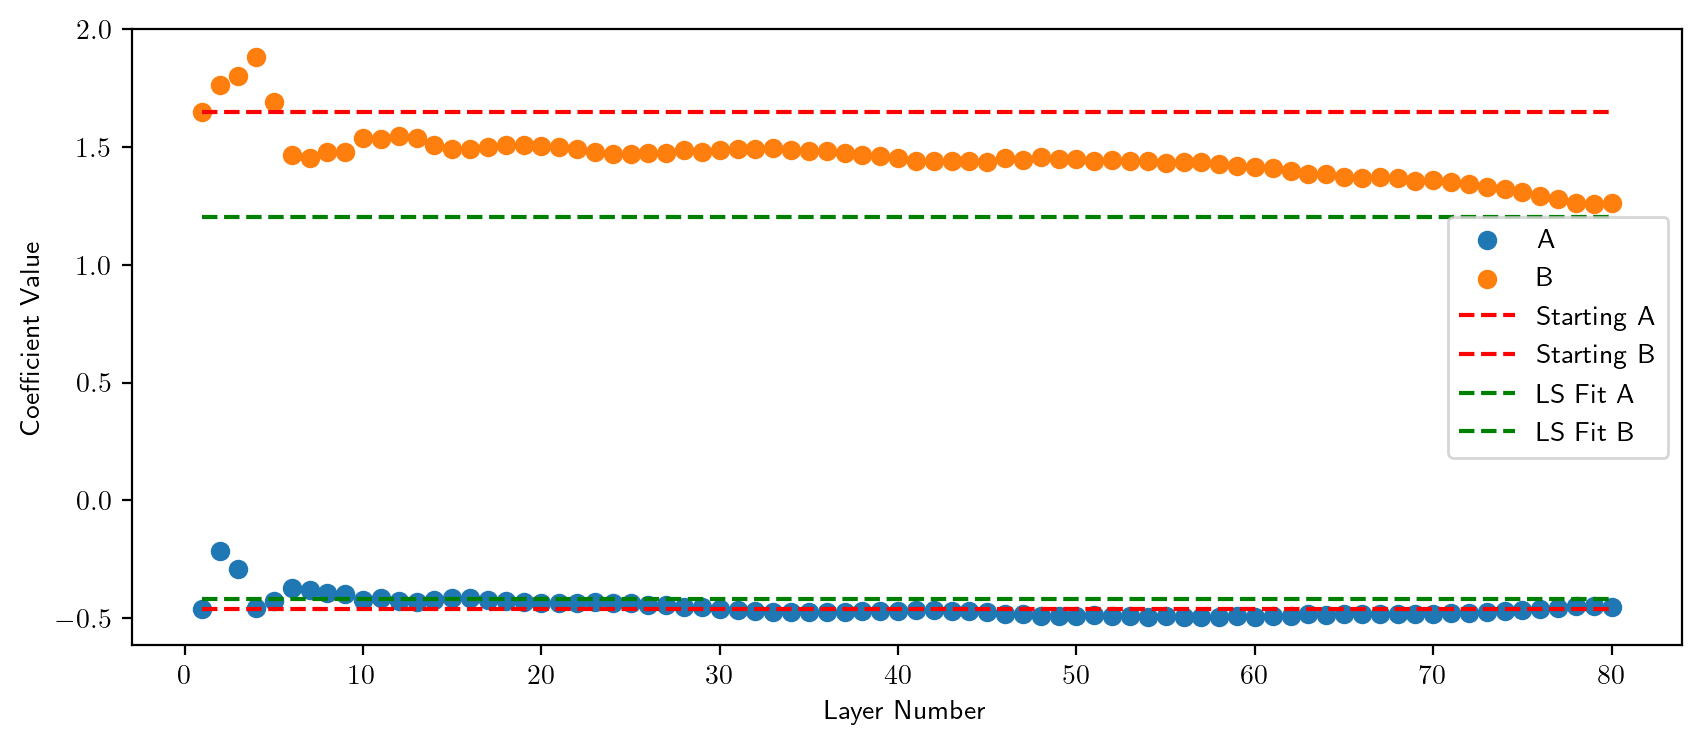

In [66]:
num_layer_start = 1  ###modify layer num here
num_layer_end = 80
## Plotting Model Coefficients
recorded_dir = "../../../recorded_data/ER4043_bent_tube_2024_09_03_13_26_16/"
model_coeff = []
for layer in range(num_layer_start, num_layer_end+1):
    model_coeff.append(np.loadtxt(f"{recorded_dir}layer_{layer}/coeff_mat.csv"))
model_coeff = np.array(model_coeff)
print(model_coeff.shape)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,4)
fig.set_dpi(200)
ax.scatter(layers, model_coeff[:,0])
ax.scatter(layers, model_coeff[:,1])
# initial Model Coeff
ax.plot([1,80],[model_coeff[0,0], model_coeff[0,0]],'r--')
ax.plot([1,80],[model_coeff[0,1], model_coeff[0,1]],'r--')
ax.plot([1,80],[x_mat[0], x_mat[0]],'g--')
ax.plot([1,80],[x_mat[1], x_mat[1]],'g--')
ax.set_xlabel("Layer Number")
ax.set_ylabel("Coefficient Value")
ax.legend(
    [
        "A",
        "B",
        "Starting A",
        "Starting B",
        "LS Fit A",
        "LS Fit B"
    ]
)
plt.show()